# Polish Bankruptcy Modelling

## Introduction

In [1]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 15.7 MB/s 
     |████████████████████████████████| 199 kB 57.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
device = torch.device(device)

cuda:0


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip

--2022-11-30 08:06:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8834471 (8.4M) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>]   8.42M  5.64MB/s    in 1.5s    

2022-11-30 08:06:33 (5.64 MB/s) - ‘data.zip’ saved [8834471/8834471]



In [4]:
!unzip data.zip

Archive:  data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


In [5]:
import pathlib 
import pandas as pd 
from scipy.io.arff import loadarff


dflist = [pd.DataFrame(loadarff(fp)[0]) for fp in pathlib.Path('.').glob('*.arff')]
df = pd.concat(dflist, axis=0)
df['class'] = df['class'].apply(lambda x: int(x.decode()))
df

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.159290,0.46240,0.07773,1.16830,-44.8530,0.467020,0.189480,0.828950,1.12230,0.383300,...,0.108990,0.415570,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.05600,0
1,-0.127430,0.46243,0.26917,1.75170,7.5970,0.000925,-0.127430,1.162500,1.29440,0.537570,...,-0.089372,-0.237040,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.47250,0
2,0.070488,0.23570,0.52781,3.23930,125.6800,0.163670,0.086895,2.871800,1.05740,0.676890,...,0.054286,0.104130,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.78180,0
3,0.136760,0.40538,0.31543,1.87050,19.1150,0.504970,0.136760,1.453900,1.11440,0.589380,...,0.102630,0.232030,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.64840,0
4,-0.110080,0.69793,0.18878,1.27130,-15.3440,0.000000,-0.110080,0.432820,1.73500,0.302070,...,0.439880,-0.364400,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.03600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,0.018371,0.47410,-0.13619,0.60839,-18.4490,0.018371,0.018371,0.972030,1.01210,0.460840,...,0.011909,0.039866,0.98809,0.274140,73.5050,79.2370,31.268,11.6730,5.14890,1
7023,-0.013359,0.58354,-0.02265,0.92896,-42.2320,-0.013359,-0.015036,0.562890,0.98904,0.328470,...,-0.011082,-0.040671,1.01110,0.805920,10.5990,7.1740,94.092,3.8792,1.75720,1
7024,0.006338,0.50276,0.43923,1.87360,9.7417,0.006338,0.012022,0.983560,1.00830,0.494490,...,0.008258,0.012817,0.99174,0.000000,10.4700,6.0759,51.019,7.1542,62.00100,1
7025,-0.041643,0.84810,-0.12852,0.57485,-121.9200,0.000000,-0.036795,0.179010,0.42138,0.151820,...,-0.232720,-0.274290,0.98788,3.593100,39.7030,3.1420,261.850,1.3939,0.51005,1


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'Attr1': 'Attr64'], 
                                                    df['class'].values, test_size=.2, random_state=42, 
                                                    stratify=df['class'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, 
                                                      random_state=123, stratify=y_train)

In [18]:
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SVMSMOTE 
from sklearn.pipeline import make_pipeline 
from sklearn.feature_selection import f_classif, SelectKBest
import numpy as np


svm_smote = SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
imputer = SimpleImputer() 
scale = StandardScaler()
fs = SelectKBest(f_classif, k=20) 
data_processing = make_pipeline(imputer, fs, scale) 

X_train_res = data_processing.fit_transform(X_train, y_train) 
X_train_res, y_train_res = svm_smote.fit_resample(X_train_res, y_train) 

X_test = data_processing.transform(X_test) 
X_valid = data_processing.transform(X_valid)

print(X_train_res.shape) 
print(X_test.shape) 
print(np.sum(y_train_res)) 
print(np.sum(y_test)/len(y_test))

(59490, 20)
(8681, 20)
29745
0.048151134661905313


In [19]:
from torch.utils.data import Dataset, DataLoader 
import torch 


class DS(Dataset): 
  def __init__(self, features, labels): 
    self.features = torch.tensor(features).type(torch.float).to(device)
    self.labels = torch.tensor(labels).type(torch.float).to(device) 

  def __len__(self): 
    return len(self.features) 
  
  def __getitem__(self, i): 
    return self.features[i, :].reshape(1, -1), self.labels[i].reshape(1, -1) 


In [20]:
test_dataloader = DataLoader(DS(X_test, y_test), batch_size=64)
valid_dataloader = DataLoader(DS(X_valid, y_valid), batch_size=64)

In [36]:
import torch 
from torch import nn 
import torch.nn.functional as F


class SimpleMultiLayerPerceptron(nn.Module): 
    def __init__(self, n_inputs, n_hidden_layer1, n_out=1): 
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(n_inputs, n_hidden_layer1, dtype=torch.float),
            nn.ELU(),
            nn.Linear(n_hidden_layer1, n_out, dtype=torch.float)
        )
        
    def forward(self, x): 
        x = self.relu_stack(x)
        return x 



100%|██████████| 23300/23300 [01:50<00:00, 210.83it/s]


Recall: 0.459 Precision: 0.120


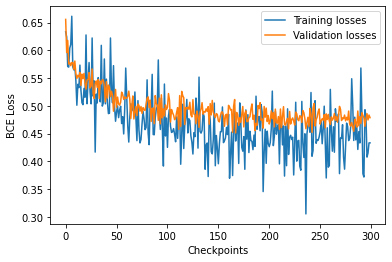

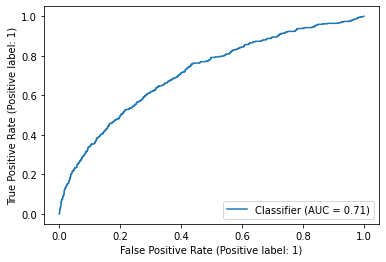

In [52]:
from torch.nn import BCEWithLogitsLoss
import torch.optim 
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, RocCurveDisplay


net = SimpleMultiLayerPerceptron(20, 40, 1)
net.to(device)

loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.9)
# scheduler = ExponentialLR(optimizer, gamma=0.9)

BATCH_SIZE = 256
MAX_EPOCHS = 100
CHKPT = 100
WIDTH = (len(X_train_res) // BATCH_SIZE) + 1

train_dataloader = DataLoader(DS(X_train_res, y_train_res), batch_size=BATCH_SIZE,
                              shuffle=True)


with tqdm(total=MAX_EPOCHS*WIDTH) as t: 
  training_losses, validation_losses = [], []
  for epoch in range(MAX_EPOCHS): 
      for it, (batch, labels) in enumerate(train_dataloader): 
          output = net(batch) 
          loss = loss_fn(output, labels) 

          optimizer.zero_grad() 
          loss.backward()
          optimizer.step()

          t.update(1)

          if (it+1) % CHKPT == 0 or it==WIDTH-1:
              loss = loss.item()
              training_losses.append(loss)
              with torch.no_grad(): 
                valid_loss,n = 0,0
                for valid_batch, valid_labels in valid_dataloader: 
                  valid_output = net(valid_batch) 
                  valid_loss_ = loss_fn(valid_output, valid_labels) 
                  valid_loss += valid_loss_.item()
                  n += 1
              valid_loss /= n
              validation_losses.append(valid_loss)
            
      scheduler.step(valid_loss)
      # scheduler.step()

recall, precis = 0, 0
no_pos_sample, no_pos_pred = 0,0
with torch.no_grad(): 
    for batch, labels in test_dataloader: 
        pred = net(batch) 
        pred = torch.sigmoid(pred)
        pred = (pred >= 0.5).type(torch.float)

        recall += (pred[labels==1] == labels[labels==1]).type(torch.float).sum().item()
        precis += (pred[pred==1] == labels[pred==1]).type(torch.float).sum().item()
        no_pos_pred += (pred==1).type(torch.float).sum().item()
        no_pos_sample += (labels==1).type(torch.float).sum().item()

recall /= no_pos_sample
precis /= no_pos_pred
print(f"Recall: {recall: >0.3f} Precision: {precis: >0.3f}")

plt.plot(training_losses, label='Training losses') 
plt.plot(validation_losses, label='Validation losses') 
plt.xlabel('Checkpoints') 
plt.ylabel('BCE Loss') 
plt.legend()


with torch.no_grad(): 
  score = net(torch.tensor(X_test).type(torch.float).reshape(-1,1,20).to(device))

score = torch.sigmoid(score)
if device.type == 'cuda': 
  score = score.cpu()
  score = score.detach()
score = score.numpy().reshape(-1, 1)

RocCurveDisplay.from_predictions(y_test, score)